## Логистическая регрессия

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

### Функция потерь выглядит след образом $$ \frac{1}{N} \sum_{i=1}^{N} \ln(1 + e^{-y_i w^T x_i})$$

### Следовательно веса будем менять следующим образом
$$w_0(t+1) = w(t) + y_i ( \frac{\eta}{1+e^{y_iw^Tx_i}} ) $$

$$w_j(t+1) = w(t) + y_i \cdot x_{ij}(\frac{\eta}{1+e^{y_iw^Tx_i}}) $$

# Реализация модели

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, penalty='l2'):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.penalty = {
            'l1': 'l1',
            'l2': 'l2'
        }[penalty]
        
        self.penalty_derivative = {
            'l1':'l1_derivative',
            'l2':'l2_derivative'
        }[penalty]
    
    def fit(self, X, y=None):
        self.w_ = np.zeros(X.shape[1] + 1)
        self.cost_ = []
        for _ in range(self.max_epoch):
            X, y = self.shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                part = (self.alpha / (1 + np.exp(target * (np.dot(xi, self.w_[1:]) + self.w_[0]))))
                self.w_[0]  += target * part - self.alpha*self.reg_der(self.w_[0], self.C)
                self.w_[1:] += target * part*xi - self.alpha* self.reg_der(self.w_[1:] , self.C)
                cost.append(np.log(1 + np.exp(-target*(np.dot(self.w_[1:], xi) + self.w_[0]))) + self.regularization(self.w_, self.C))
            self.cost_.append(sum(cost)/len(y))
        '''
        Обучение модели
        '''
        
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        y_hat= np.where(self.predict_proba(X) > 0.5, 1, -1 )
        '''
        Возвращение метки класса
        '''
        return y_hat
    
    def predict_proba(self, X):
        wx = np.dot(X, self.w_[1:]) + self.w_[0]
        y_hat_proba = 1 / (1 + np.exp(-wx))
        '''
        Возвращение вероятности каждого из классов
        '''
        return y_hat_proba
    
    def shuffle(self, X, y):
        t = np.random.permutation(len(y))
        return X[t], y[t]
    
    def l1(self, w,c):
        return (1/c)*np.sum(np.abs(w))

    def l2(self, w,c):
        return (1/c)*np.dot(w,w)

    def l1_derivative(self, w,c):
        return (1/c)*np.sign(w)

    def l2_derivative(self, w, c):
        return (1/c)*w
        
    def regularization(self, w, c):
        method=getattr(self, self.penalty, lambda :'l2')
        return method(w, c)
    
    def reg_der(self, w, c):
        method=getattr(self, self.penalty_derivative, lambda :'l2')
        return method(w, c)
        

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

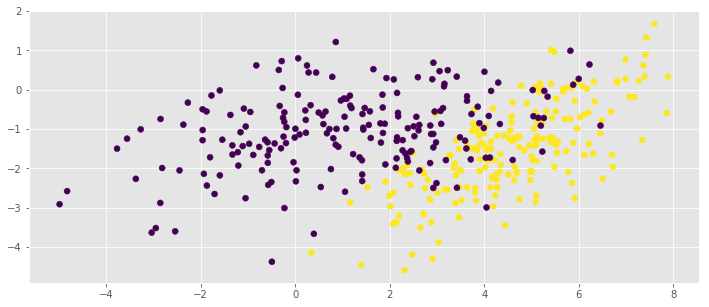

In [4]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [5]:
y[y==0] = -1 # переведем метки класса в 1 и -1

In [43]:
models=[]
for i in [1, 0.1,0.001]:
    model = MySGDClassifier(C=1000, alpha=0.01, max_epoch=10, penalty='l2')
    model.fit(X, y)
    models.append(model)

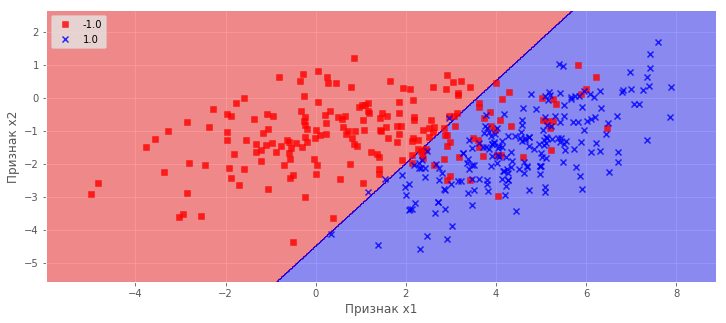

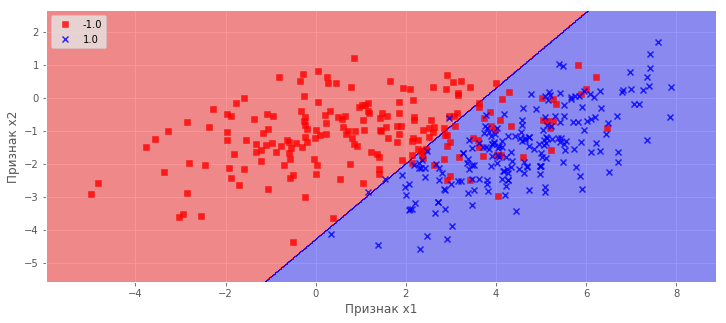

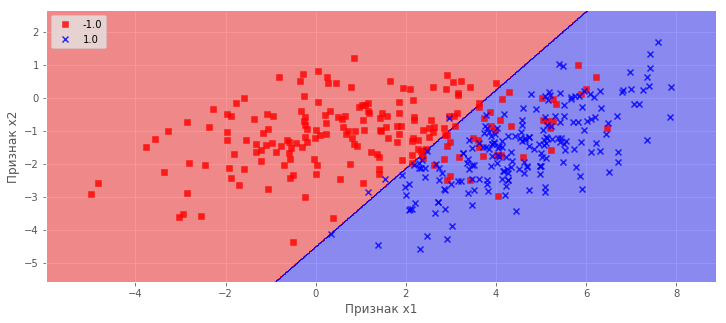

In [44]:
from matplotlib.colors import ListedColormap
## Your Code Here
def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ( 's', 'x','o')
    colors = ('red','blue', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    #
    xl_min, xl_max = X[:, 0].min() - 1, X[:,0].max() +1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() +1
    xxl,xx2 = np.meshgrid(np.arange(xl_min, xl_max, resolution),np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xxl.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xxl.shape)
    plt.contourf(xxl,xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xxl.min(), xxl.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx ,cl in enumerate(np.unique(y)) :
        plt.scatter(x=X[y == cl, 0],y=X[y==cl, 1], alpha=0.8, c=cmap(idx) , marker=markers[idx] , label=cl)


for  model in models:
    plot_decision_regions(X,y, classifier=model)
    plt.xlabel('Признак x1')
    plt.ylabel('Признак x2')
    plt.legend(loc='upper left')
    plt.show()


## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

In [46]:
markers = ['o', 'x', '.']
colors = ['r', 'b', 'k']
for  model in models:
    plt.plot(range(1, len(model.cost_) + 1), color=colors[models.index(model)], model.cost_, marker=markers[models.index(model)])


plt.xlabel('Эпохи')
plt.ylabel('Средняя стоимость')
plt.show()

SyntaxError: positional argument follows keyword argument (<ipython-input-46-86dd92c62a8a>, line 4)